# Understanding Gradient Descent

In [39]:
#collapse
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [40]:
#collapse
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In recent years, with the increase in computing speed, increaed access to GPUs (Graphics Processing Unit) and enhanced machine learning libraries, Gradient descent has become an intergral part of many machine learning and deep learning processes, especially those associated with Neural Networks.  

We will begin by defining what Gradient Descent is, why it is useful and how it is used in practice.  We will illustrate this with a simple example.  This example if from the fastai course and book *Deep Learning for Coders with fastai and PyTorch*

## What is Gradient Descent?

Let's start by defining what a gradient.  If you remember back to high school calculus, a derivative of a function calculates the rate of change of a function at a specific point (rise / run).  It tells you how much the output changes if you change the inputs a tiny bit.

Well, when you have a bunch of variables in an equation, you will need to know how much the output changes if you change each of these variables a tiny bit.  This is done by calculating the partial derivatives with respect to each of the variables.  And the gradient is the vector which basically stores all of this information.

Gradient Descent is simply the algorithm that uses this information to update a model's parameters a little at a time improving its' predictive ability.

## A Simple Example

Let's look at an example of the fictional equation of the speed of a roller coaster going over a hill for a period of time, 20.  Using PyTorch's `arange` method we can create a sequence from 0-19 for this example.

In [41]:
time = torch.arange(0, 20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

We will then simply create a random function which has the speed decreasing to 0 at the midpoint and increasing again after.  We will also add some random noise using `randn`.  And we will graph what the function looks like.

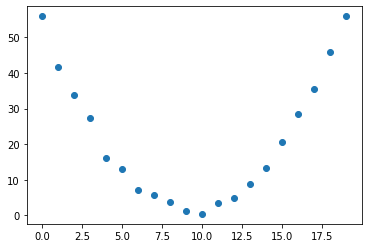

In [42]:
speed = torch.randn(20)*2 + 0.6*(time-9.5)**2 + 1 
plt.scatter(time, speed);

Next, we will estimate that the function is a quadratic is the form
$ a t^2 + bt + c$ and will look to solve for a, b, c.  Let's define the function.

In [43]:
def f(t, params):
    a, b, c = params
    return a*(t**2) + (b*t) + c

How will we know if our estimated paramters are good or not?  We need to create a loss function that calculates the error rate of our predictions against the actual data.  In our case, we will use a simple Mean Squared Error loss function.  To calculate this, we simply:  

1) Calculate the difference between our predictions and our target values  
2) Square the difference  
3) Take a mean of the Squared differences.  

This is the loss function that we will use Gradient Descent to minimize.

In [44]:
def mse(preds, target):
    return ((preds - target)**2).mean()

### Seven-Step Process

Now, we begin the process of Gradient Descent, which involves seven-steps.  

1) Initialize the parameters  
2) Calculate the predictions  
3) Calculate the loss  
4) Calculate the gradients  
5) Step the weights  
6) Repeat steps 2) through 5)  
7) Stop the process  

#### Step 1: Initialize the Parameters

We begin by setting the initial values for our parameters.  We will do so in a simple random manner utilizing `randn` again.

We will also add the method `.requires_grad_()`.  This tells PyTorch that remember the necessary information so that we can later calculate the gradients with respect to these parameters.

In [45]:
params = torch.randn(3).requires_grad_()

#### Step 2: Calculate the Predictions

In this step, we will calculate the predictions based on our current parameter estimates.  We will also write a quick function to view our targets results along with our current estimates.

In [46]:
preds = f(time, params)

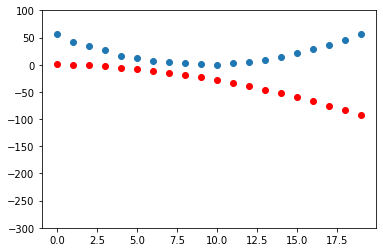

In [47]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')  # to_np() converts a tensor to an array
    ax.set_ylim(-300, 100)

show_preds(preds)

These predictions look pretty terrible.  But hopefully, our Gradient Descent algorithm will help improve these results

#### Step 3: Calculate the loss

In this step, we will simply calcualte the loss using our `mse` function that we previously created.  As you can see from the output, the information for the gradient is also created along with the result.

In [48]:
loss = mse(preds, speed)
loss

tensor(4406.9209, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients

In this step, we will calculate the gradients.  And thankfully, we won't have to do this calcuation manually, PyTorch does this all on its' own.  And as you can see from the results, it returns the gradient for each of our parameters.

In [49]:
loss.backward()
params.grad

tensor([-21275.2949,  -1369.6201,   -108.7108])

#### Step 5: Step the parameters

Here, we will update the parameters of our model, but how?  From the last step we know how much our loss function will change as we change our parameters, but how much should we adjust them by?  If we adjust our parameters too fast, we run the risk of overshooting our optimal solution and simply bouncing back and forth and never converging to an answer.  If we adjust our parameters too slowly, it will take a long time to converge to an optimal solution.  Additionally, we may be fooled if there are local minimums in the function and if we see the loss going back up, we may interpret that as an incorrect global minimum.  

The number that we use as a scalar of the gradients is called the **learning rate**.  There is no answer as to what the correct learning rate is, this can be a tunable parameter in the model, where we can try a few different rates and choose the best performing one.  For this purpose, we will use 1e-5 as our learning rate.

Another step with we need to do after adjusting the parameters is to zero-out the gradients for our next iteration, as PyTorch we simply add any calculated gradients to the existing ones.

In [50]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

#### Step 6: Repeat the process

Here, we will go back to step #2 and #3.  We will make the predictions with our new parameters and calculate the loss and visualize our new predictions.

In [51]:
preds = f(time, params)
mse(preds, speed)

tensor(1145.6825, grad_fn=<MeanBackward0>)

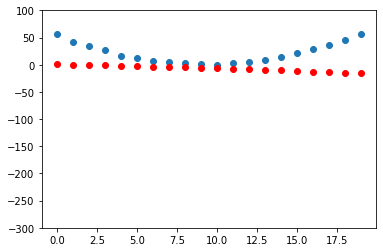

In [52]:
show_preds(preds)

We've improved our Mean Squared Error from 4,406 to 1,145. Not too bad, for only updating the parameters once.  Let's write a function including everything we've done so far, so we can repeat the process a few more times.

In [53]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [54]:
for i in range(10):
    apply_step(params)

1145.6824951171875
528.5543212890625
411.7728576660156
389.67218017578125
385.4880065917969
384.6941833496094
384.54205322265625
384.5111999511719
384.50335693359375
384.499755859375


#### Step 7: Stop the process

We have decided to stop after an additional 10 epochs arbitrarily.  In practice, we would likely watch the loss function and our metrics to decide when to step.  But here we have seen our Mean Squared Error be reduced from 4,406 to 385, in only 6 epochs.


## Summary

From this simple example, I think you can begin to see the power of using the Gradient Descent algorithm to update model paramters to improve performance.